# What is FastAPI?
FastAPI is a modern, fast Python web framework for building APIs. It's built on top of Starlette for web routing and Pydantic for data validation.  

**Recommended file structures:**   
structure the project/app as a package (folder with `__init__.py`)

```text
app/
├─ __init__.py
├─ main.py               # FastAPI app creation, startup events
├─ api/                  # Routers and request handling
│   ├─ __init__.py
│   ├─ v1/
│   │   ├─ __init__.py
│   │   ├─ users.py      # router
│   │   └─ items.py      # router
│   └─ deps.py           # common dependencies (e.g., DB session, get_db())
│
├─ core/                 # Configuration & utilities
│   ├─ __init__.py
│   ├─ config.py         # settings, environment variables
│   └─ security.py       # JWT, hashing utilities (if needed)
│
├─ models/
│   ├─ __init__.py
│   ├─ user.py           # SQLAlchemy ORM models/Pydantic models
│   └─ item.py
│
├─ schemas/
│   ├─ __init__.py
│   ├─ user.py           # Pydantic schemas for request/response
│   └─ item.py
│
├─ db/
│   ├─ __init__.py
│   ├─ base.py           # Base metadata
│   ├─ session.py        # DB engine, session factory
│   └─ init_db.py        # initial setup
│
└─ services/
    ├─ __init__.py
    └─ user_service.py   # business logic
```

Why use __init__.py and make it a package:   
- Allows relative imports (`from .routers import users`)       
    without it: `from app.routers.users import router`
- Allows modular structure
- Easier to test (pytest likes packages)
- Plays well with deployment tools
- Keeps project organized as it grows

## Basic
### 1. Main app instance and Home page   

The `FastAPI()` constructor creates the main application instance. You can configure it with parameters like `title` for API documentation.   

```python
# file 1_basic_app.py: 
from fastapi import FastAPI

app = FastAPI(
    title="fast api project"
)

@app.get('/')
def home():
    return {'message': 'hello world'}
```
```bash
# then run:
fastapi dev 1_basic_app.py
```

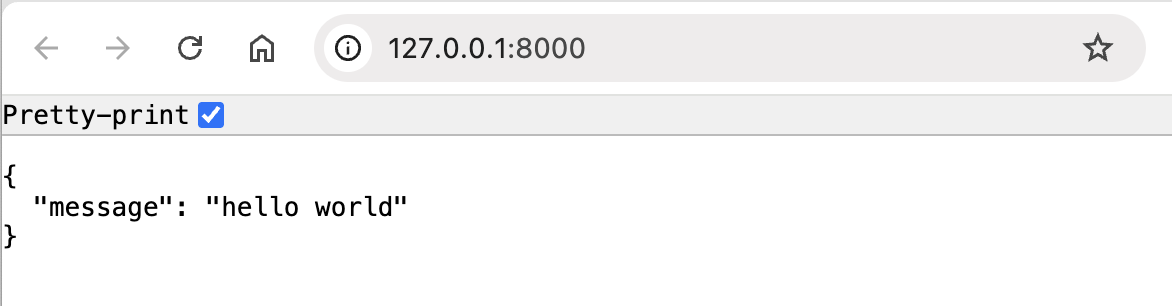

### 2. Dynamic route
make use of python's typing
```python
@app.get('/items/{item_id}') # no need to announce type here
def get_item(item_id:int):  # without int also works
    return {
        'the input item id: ': item_id
    }
```

little bit different with flask:
```python
@app.route('/items/<int:item_id>')
def get_item(item_id):
    ...
```

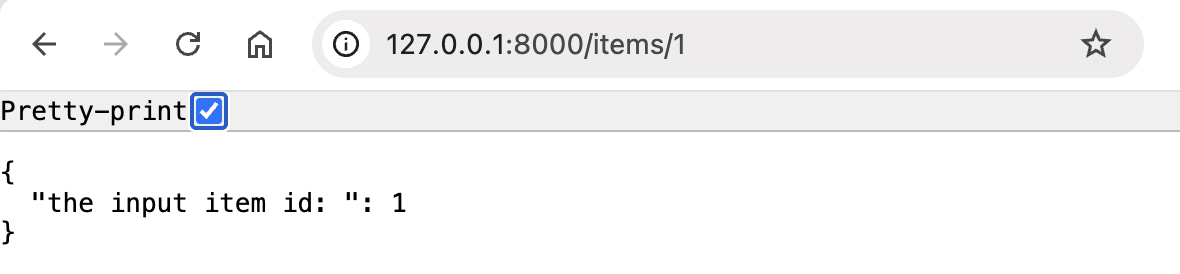

### 3. Query
to use query in rounting, add query element as an argument: 
```python
@app.get('/items/{item_id}')
def get_item(item_id: int, limit: int | None=None):
    return {
        'the input item id: ': item_id,
        'limit': limit
    }
```
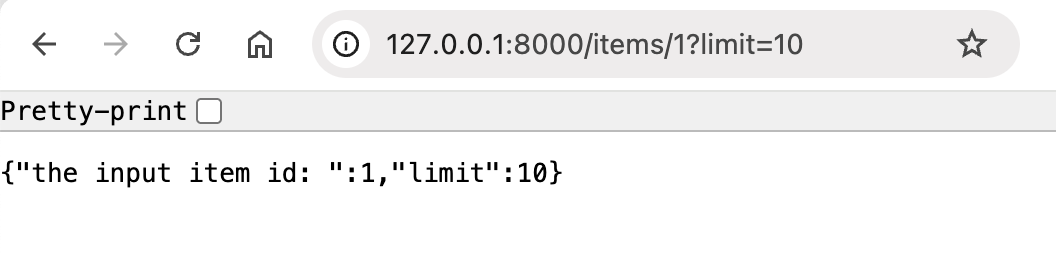

### 4. Header()
```python
from fastapi import Header
@app.get('...')
def get_item(
    ...
    user_agent: str = Header(...)
):
```
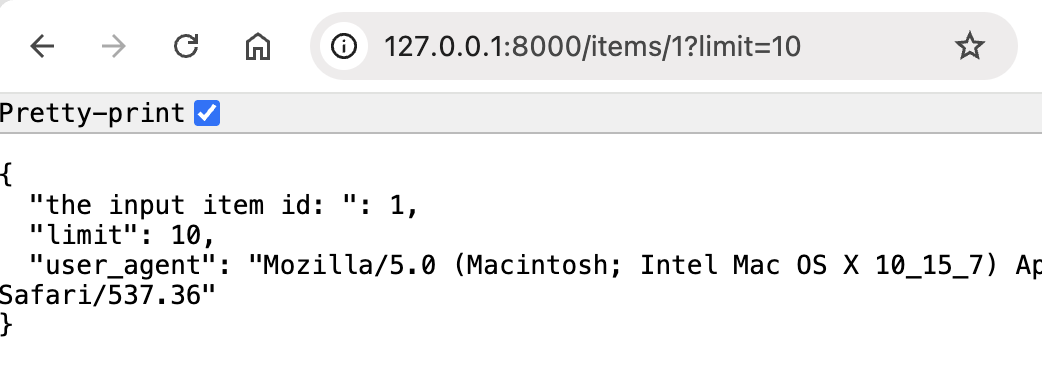

What Header(...) Does: 
1.	**Declaring a Header Parameter**    
	- In FastAPI, using Header(...) on a function parameter tells FastAPI: “This value should come from an HTTP header, not from the path, query, or body.”  ￼
	- Without Header(...), FastAPI would treat the parameter as a query parameter by default.  ￼
2.	**Required vs Optional**    
	- When you write user_agent: `str = Header(...)`, the ... (Ellipsis) means this header is required. FastAPI will validate that the header is provided; if not, it will error out.  ￼
	- If you used `Header(None)` (or some default value), then the header would be optional.  ￼
3.	**Automatic Name Conversion**   
	- HTTP headers use dashes (e.g. User-Agent), but Python variable names usually use underscores (user_agent). FastAPI automatically converts from the underscore in user_agent to the dashed header name User-Agent.  ￼
	- If for some reason you don’t want FastAPI to convert underscores, you can disable it with convert_underscores=False:  
		`user_agent: str = Header(..., convert_underscores=False)`

### 5. API Documentation (Swagger UI)

FastAPI automatically generates **interactive API documentation** based on OpenAPI. No extra code needed!

Once your server is running:
- **Swagger UI**: `http://localhost:8000/docs`
- **ReDoc**: `http://localhost:8000/redoc`
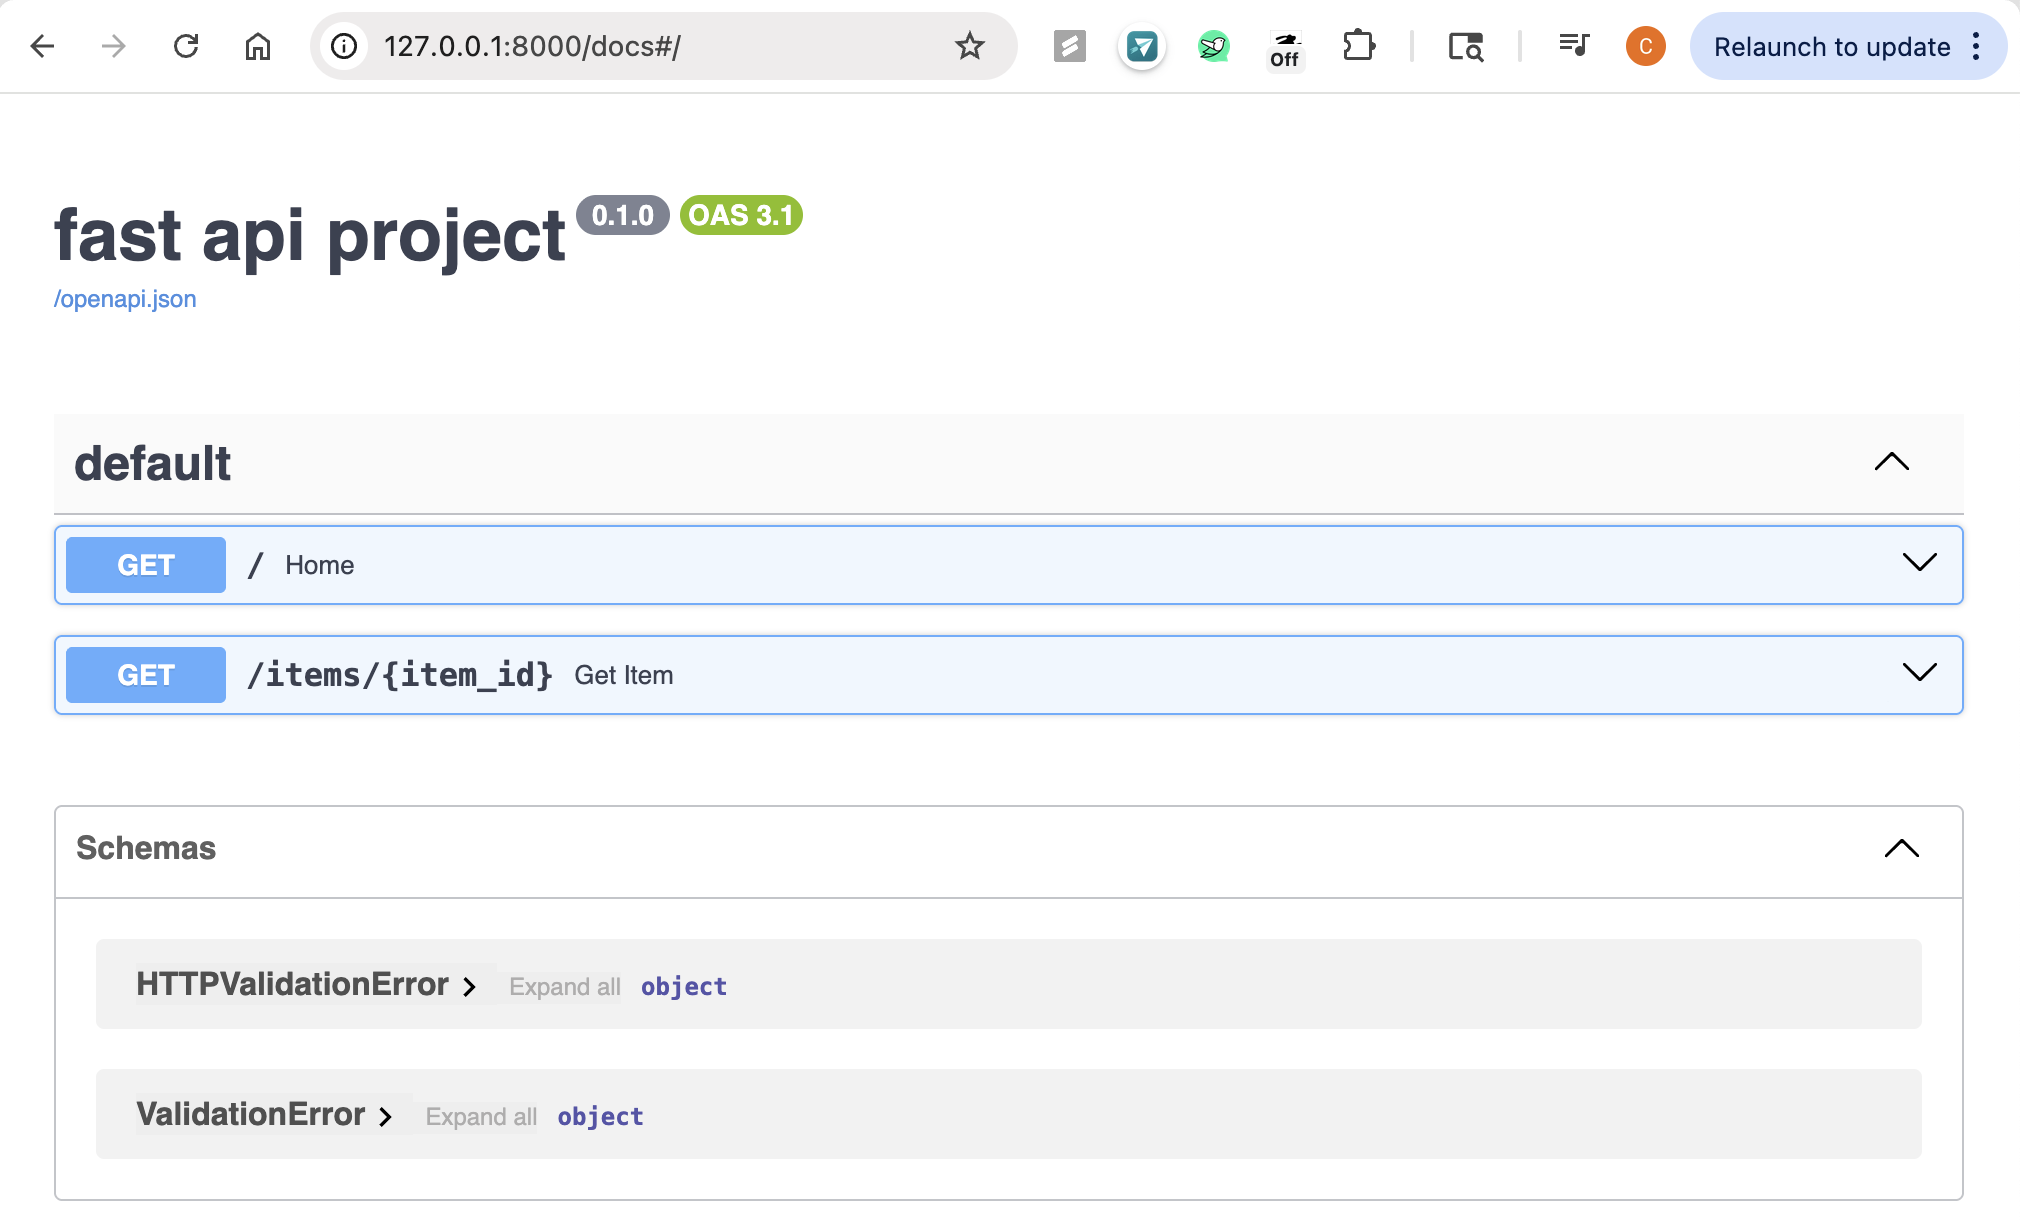
What Gets Documented Automatically:   
1. **All endpoints** with their HTTP methods
2. **Path parameters** with descriptions
3. **Query parameters** with constraints
4. **Request body schemas** from Pydantic models
5. **Response schemas**
6. **Docstrings** from route handlers

#### Example Documentation
```python
@app.get('/items/{item_id}')
def get_item(...):
    '''
    This api is to fetch item by id
    '''
    return ...
```
The doc even shows the comments in the function:  
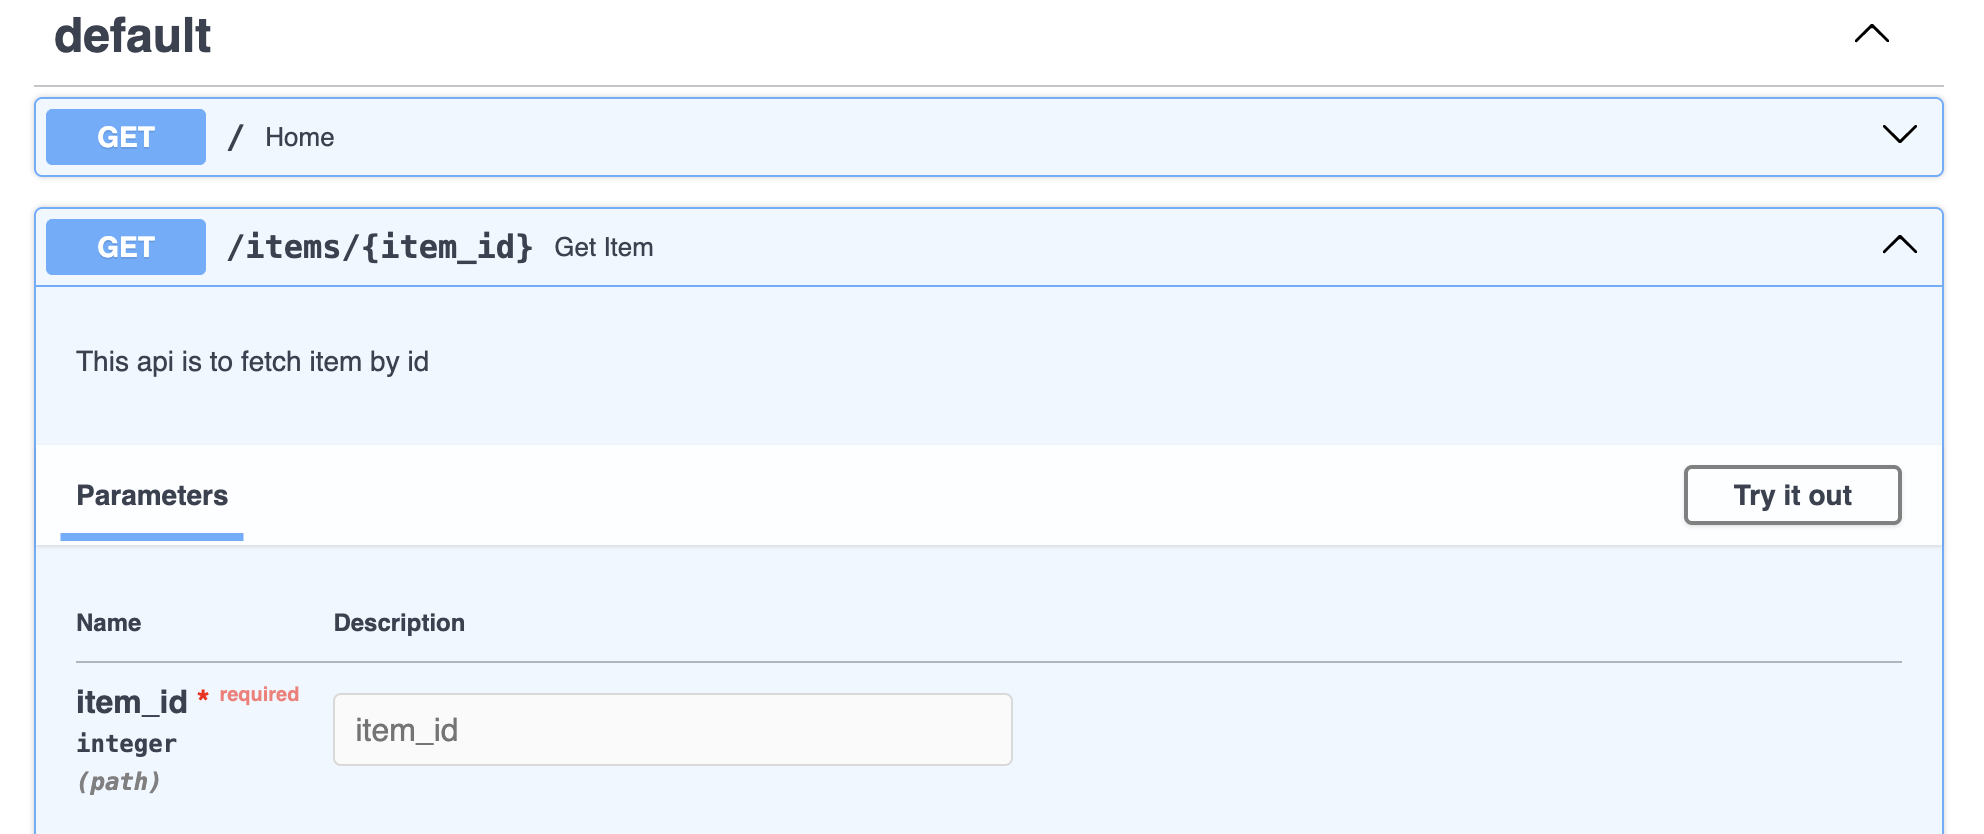

In Swagger UI, this will show:
- Endpoint: `GET /items/{item_id}`
- Description: "This api is to fetch item by id"
- Parameters with their types and descriptions
- Try-it-out functionality to test the endpoint directly.
    ```python
    @app.get('/items/{item_id}')
    def get_item(
        # with validation: 
        item_id: int = Path(..., description='Item id in path'), 
        limit: int | None=Query(None, lt=100, description='max items to return'),
        user_agent: str = Header(...)
    ):
    ```   
    if input limit greater than 100, can just return the validation result:
  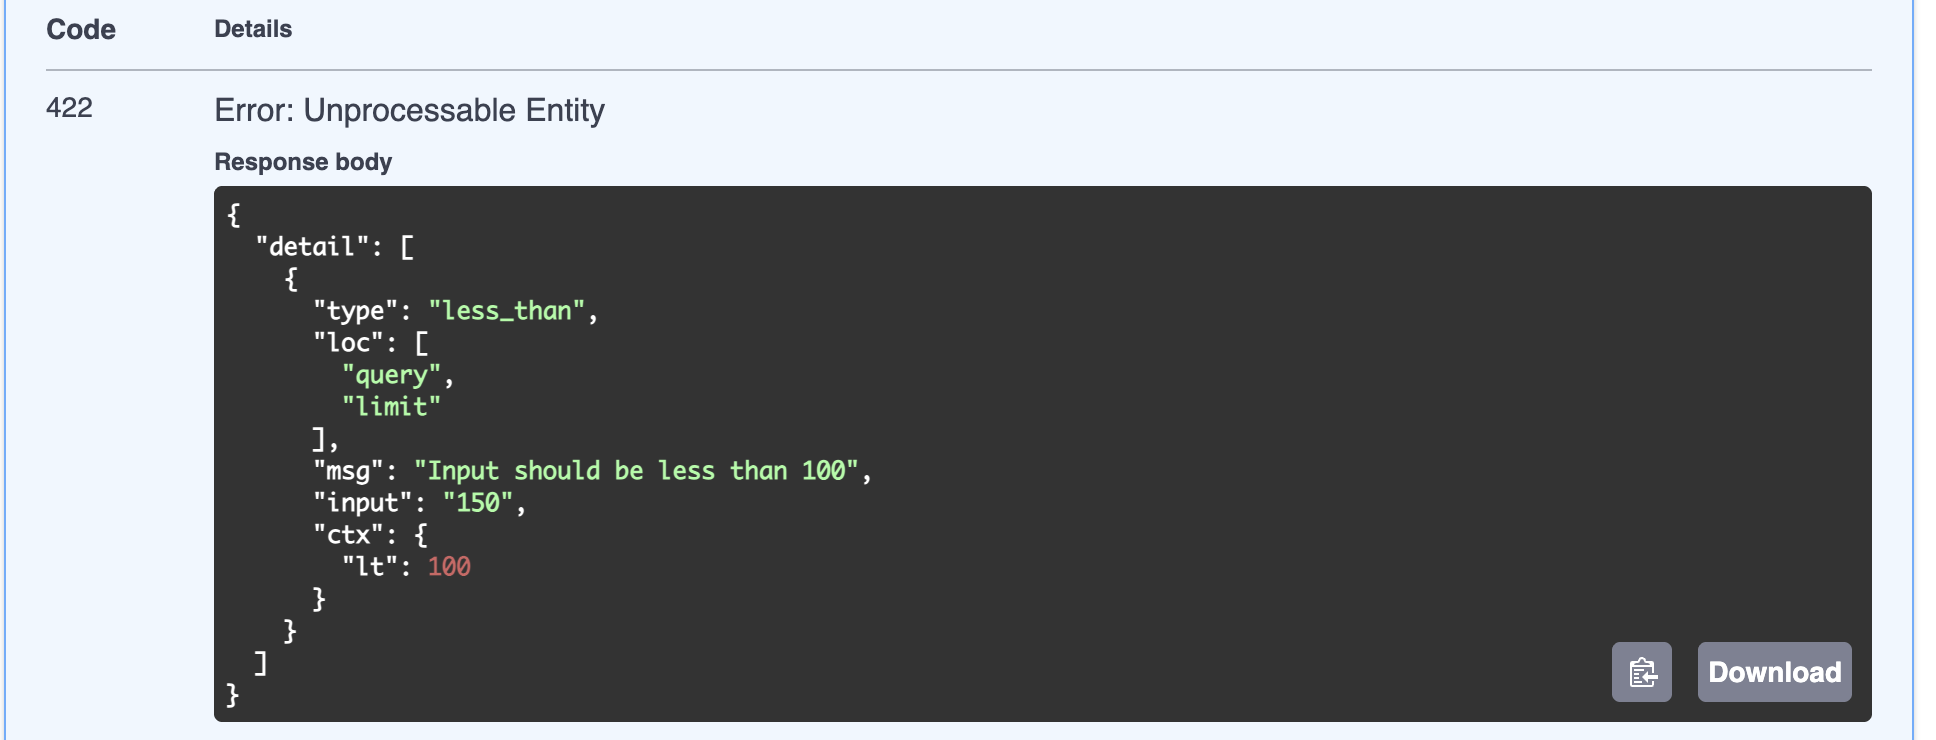

#### Customizing Documentation

You can customize the documentation through the `FastAPI()` constructor:

```python
app = FastAPI(
    title="Task Management API",
    description="API for managing tasks with weather forecasts",
    version="1.0.0",
    docs_url="/documentation",  # Change docs URL
    redoc_url="/redoc-alternative"
)
```

#### Response Schema Documentation

Using Pydantic models for responses automatically documents them:
```python
class NoteResponse(Notebase):
    id: int
    user_id: int
    created_at: datetime
    udpated_at: datetime
    
    class Config:
        from_attributes = True

@app.get("/notes/{note_id}",         response_model=NoteResponse)
def get_note(note_id: int):
    # FastAPI will validate the response matches NoteResponse
    return note
```

#### Interactive Testing in Swagger UI

The Swagger UI allows you to:
1. Click "Try it out" on any endpoint
2. Fill in parameters
3. Execute the request
4. See the response with status code and data

This makes it easy to test your API without writing separate test code or using tools like Postman during development.


# API Validation

## Validation with Pydantic Models
FastAPI uses Pydantic for automatic request/response validation.

```python
# in validation_schemas.py:
from pydantic import BaseModel, Field

class Notebase(BaseModel):
    title: str = Field(..., min_length=1, max_length=200)
    content: str = Field(..., min_length=1)

# in 6_validation.py:
from validation_schemas import Notebase
@app.post('/test-validation')
def test_validation(note:Notebase):
    return {
        'received': note.model_dump()
    }
```

**Field Parameters:**
- `...` means required (no default value)
- `min_length`: Minimum string length
- `max_length`: Maximum string length
- `default`: Default value if not provided

input try it out, if validation fails:   FastAPI automatically returns a **422 Unprocessable Entity** response with detailed error information
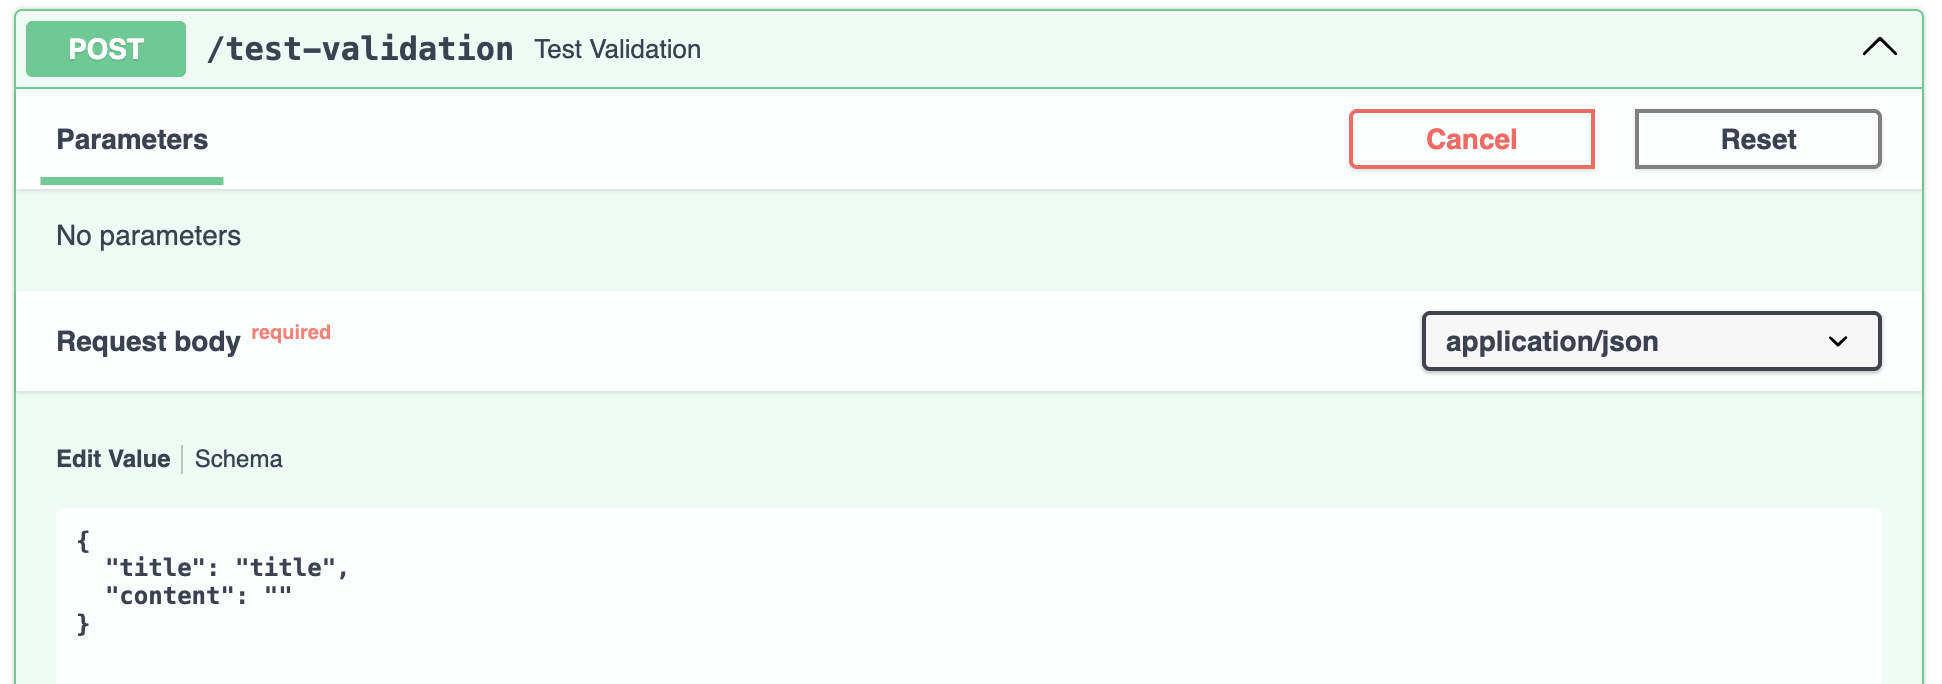
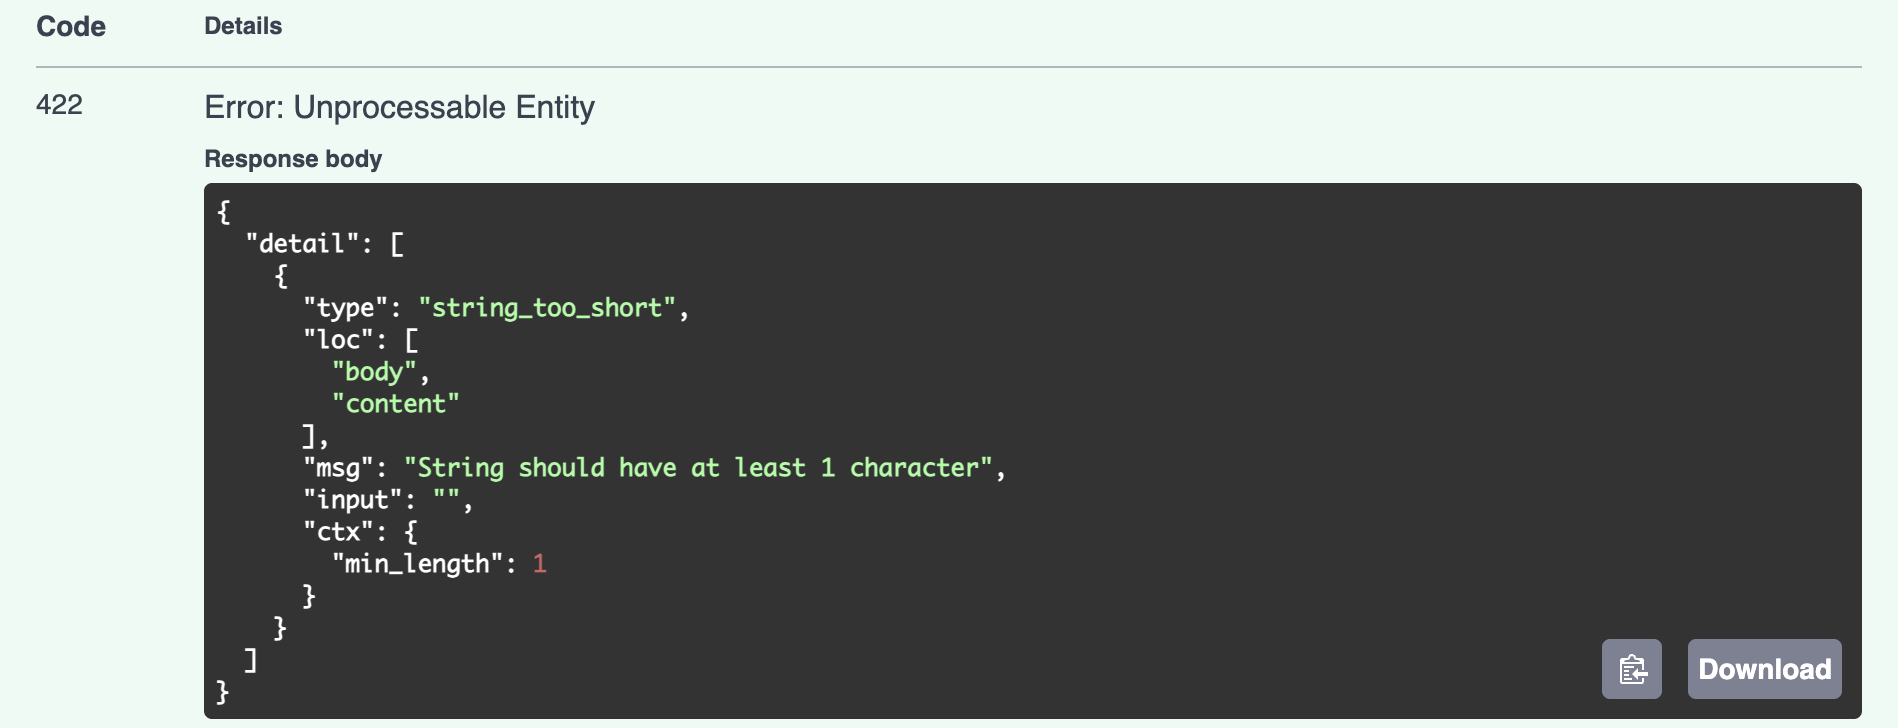

if validated:
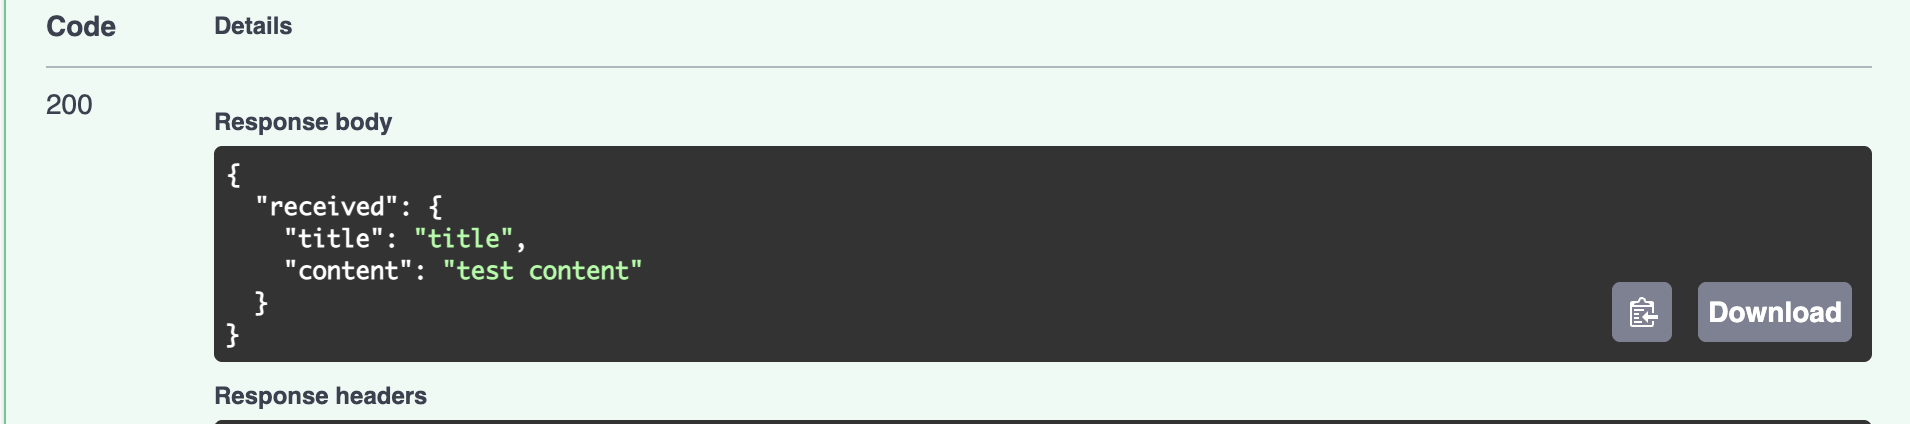

## Path, Query, Header, Body Parameters

**Path Parameters:**
```python
@app.get('/items/{item_id}')
def get_item(
    item_id: int = Path(description="item id to query")
):
    return {'item_id': item_id}
```

**Query Parameters:**
```python
@app.get('/items/{item_id}')
def get_item(
    limit: Optional[int] = Query(None, lt=100, description="max items to return")
):
    # Accessed as: /items/1?limit=50
    return {'limit': limit}
```

**Header Parameters:**
```python
@app.get('/items/{item_id}')
def get_item(
    user_agent: str = Header(...)
):
    return {'user_agent': user_agent}
```

**Body Parameters:**
```python
@app.post('/test-validation')    
def test_validation(
    note: Notebase = Body(...)
):
    return {'received': note.model_dump()}
```



# Dependency Injection
a design pattern where you provide ("inject") dependencies to a function rather than creating them inside the function. FastAPI handles this automatically.   

**Without it:** 
we have to call session multiple times 
```python
@router.post('/notes')
def create_note(note: NoteCreate):
    # Create database session inside the function
    with Session(engine) as db:
        db_note = Note(title=note.title, content=note.content, user_id=1)
        db.add(db_note)
        db.commit()
        return db_note
```
Problems:    
- Session management code repeated in every endpoint
- Hard to test (can't easily mock the database)
- Tight coupling to specific implementation

**With Dependency Injection:**   
## 1. Define the dependency (database.py):
```python
def get_session():
    with Session(engine) as session:
        yield session  # Yields the session to the endpoint
    # After endpoint finishes, code here runs (cleanup)
```
The `yield` keyword is important:

- Everything before `yield` runs before your endpoint
- The value after `yield` is injected into your endpoint
- Everything after `yield` runs after your endpoint (cleanup, close connections)

## 2. Use `Depends()` in your endpoint:
```python
@router.post('/notes')
def create_note(
    note: NoteCreate,
    db: Session = Depends(get_session)  # Tell FastAPI: "call get_session() and give me the result"
):
    # db is now the session from get_session()
    db_note = Note(
        title=note.title,
        content=note.content,
        user_id=user_id
    )
    
    db.add(db_note)
    db.commit()
    return db_note
```

## 3. Use type annotation (after Python3.9)
```python
def create_note(
    db: Annotated[Session, Depends(get_session)]
)
```

## 4. Clearer approach
- put the above in `dependency.py` (can add more others) 
- then just import and call it in endpoint
```python
# in dependency.py:
from typing import Annotated
from fastapi import Depends
from sqlmodel import Session
from app.database import get_session

DBSession = Annotated[Session, Depends(get_session)]

# in notes.py:
from dependency import DBSession
def create_note(
    db: DBSession
)
```
## Behind the Scenes
When a request comes in:

1. FastAPI sees `db: DBSession` parameter
2. Recognizes it needs to call `get_session()`
3. Calls `get_session()` → gets a `Session`
4. Passes that `Session` to your function as `db`
5. The function runs
6. FastAPI completes the `yield` in `get_session()` (cleanup happens)

This all happens automatically and request-Specific! 

# Implementation
1. build models (database tables) in `models.py` by sqlmodel
2. create engine in `database.py`, how to connect the database (url, database, schema)
3. create all schemas in `data_init.py`, and initionlize some data
4. design endpoint `./routers/notes.py`, like blueprint, can be added to main.py
5. use depency injection in endpoint:
- define the dependency `get_session` in `database.py`
- in `dependency.py`, creates a reusable type that means: "A Session object obtained via get_session dependency"

# Async and Await Concepts in FastAPI

## Synchronous vs Asynchronous Route Handlers

**Regular function (synchronous):**
```python
@app.get('/tasks/{task_id}')
def get_task(task_id: int):
    # Blocking operation - server waits here
    return {"task_id": task_id}
```

**Async function:**
```python
@app.get('/tasks/{task_id}')
async def get_task(task_id: int):
    # Non-blocking - server can handle other requests
    result = await some_async_operation()
    return result
```

### When to Use Each?

**Use `def` (synchronous) when:**
- Working with traditional databases (synchronous SQLAlchemy)
- Performing CPU-bound operations
- No I/O operations or all I/O is synchronous
- Most simple CRUD operations

**Use `async def` (asynchronous) when:**
- Making external API calls (like weather forecast APIs)
- Using async database drivers
- Handling file uploads/downloads
- Working with WebSockets
- Operations that involve waiting for external services

### Example from Homework
The homework requires async for the forecast client:
```python
@app.get("/tasks/{task_id}")
async def get_task(
    task_id: int,
    db: Annotated[Session, Depends(get_db)],
    forecast_client: Annotated[ForecastClient, Depends(get_forecast_client)]
):
    # Database query (synchronous)
    task = db.get(Task, task_id)
    
    # External API call (asynchronous)
    weather = await forecast_client.get_weather(task.city)
    
    return {**task.dict(), "weather": weather}
```

## Key Concepts
- `async def` declares an asynchronous function
- `await` pauses execution until the async operation completes, allowing other requests to be processed
- You can mix sync and async code in async functions
- FastAPI automatically handles the event loop for you

# FastAPI Unit Testing

## Testing Framework Setup
FastAPI works with standard Python testing tools:
- **pytest**: The main testing framework
- **httpx**: For making test requests (async-capable)

## Basic Test Structure
```python
from fastapi.testclient import TestClient
from main import app

client = TestClient(app)

def test_home():
    response = client.get('/')
    assert response.status_code == 200
    assert response.json() == {'message': 'hello world'}
```



## Testing with Dependencies
When testing endpoints that use dependencies (like database sessions), you can override them:

```python
from fastapi import Depends

# Override database dependency for testing
def override_get_db():
    # Use test database
    db = TestSession()
    try:
        yield db
    finally:
        db.close()

app.dependency_overrides[get_db] = override_get_db
```



## Testing CRUD Operations
```python
def test_create_task():
    response = client.post('/tasks', json={
        "title": "Test task",
        "content": "Test content",
        "city": "Tokyo",
        "user_id": 1
    })
    assert response.status_code == 201
    data = response.json()
    assert data["title"] == "Test task"
    assert "id" in data

def test_get_task_not_found():
    response = client.get('/tasks/9999')
    assert response.status_code == 404
    assert response.json() == {"detail": "Task not found"}
```


## Testing Async Endpoints
For async endpoints, use `pytest-asyncio`:
```python
import pytest
from httpx import AsyncClient

@pytest.mark.asyncio
async def test_async_endpoint():
    async with AsyncClient(app=app, base_url="http://test") as client:
        response = await client.get("/tasks/1")
        assert response.status_code == 200
```

## Custom Error Responses

You can customize validation errors:
```python
from fastapi import HTTPException

@app.get('/tasks/{task_id}')
def get_task(task_id: int, db: Session = Depends(get_db)):
    task = db.get(Task, task_id)
    if not task:
        raise HTTPException(status_code=404, detail="Task not found")
    return task
```

# Key Takeaways

1. **FastAPI is batteries-included**: Comes with validation, documentation, and type checking out of the box
2. **Use async strategically**: Only for I/O-bound operations like external API calls
3. **Pydantic handles validation**: Define schemas once, get validation and documentation automatically
4. **Documentation is free**: Swagger UI and ReDoc are generated automatically from your code
5. **Testing is straightforward**: Use TestClient for sync code, AsyncClient for async code

## Additional Resources

- **FastAPI Official Docs**: https://fastapi.tiangolo.com/
- **Pydantic Documentation**: https://docs.pydantic.dev/
- **SQLModel Documentation**: https://sqlmodel.tiangolo.com/
